In [ ]:
import pandas as pd
import plotly.express as px
import MetaTrader5 as mt5
from datetime import datetime, timedelta
from IPython.display import display

In [ ]:
# How to calculate the average spread on a symbol
mt5.initialize()

# getting tick data
symbol = 'GBPJPY'
start_datetime = datetime.now() - timedelta(days=7)
end_datetime = datetime.now()

ticks = mt5.copy_ticks_range(symbol, start_datetime, end_datetime, mt5.COPY_TICKS_ALL)
ticks_df = pd.DataFrame(ticks)
ticks_df['time'] = pd.to_datetime(ticks_df['time'], unit='s')

# calculating spread column
ticks_df['spread'] = ticks_df['ask'] - ticks_df['bid']

display(ticks_df)

# filter tick_df by main trading hours from 2-22
ticks_df['hour'] = ticks_df['time'].dt.hour

# filtering data
ticks_df_filtered = ticks_df[ticks_df['hour'].between(2, 22)]

display(ticks_df_filtered)

# calculate average spread
avg_spread = ticks_df_filtered['spread'].mean()
print('avg_spread', avg_spread)

In [ ]:
# How to include commissions and spread in the backtest. Profits and Fees are calculated in USD

# get the avg_spread from the previous analysis for the symbol that you want
symbol = 'GBPJPY'
avg_spread = 0.007749
contract_size = 100000
conversion_to_usd = 1 / 151  # based on USDJPY exchange rate

spread_fee_per_lot = avg_spread * contract_size * conversion_to_usd
commission_per_lot = 7  # set by your broker

# import backtest sample
trades_df = pd.read_csv('gbpjpy_backtest_sample.csv')
display(trades_df)

# adding fee columns
trades_df['spread_fee'] = trades_df['volume_lots'] * spread_fee_per_lot * -1
trades_df['commission'] = trades_df['volume_lots'] * commission_per_lot * -1
trades_df['net_profit'] = trades_df['profit'] + trades_df['spread_fee'] + trades_df['commission']
display(trades_df)

# compare profit (gross_profit) vs net_profit
trades_df['gross_pnl'] = trades_df['profit'].cumsum()
trades_df['net_pnl'] = trades_df['net_profit'].cumsum()

fig = px.line(trades_df, x='close_time', y=['gross_pnl', 'net_pnl'])
display(fig)

In [ ]:
# How to analyze larger candle samples for candlestick pattern recognition
candle_samples = 10

# getting ohlc data
symbol = 'GBPJPY'
start_datetime = datetime.now() - timedelta(days=7)
end_datetime = datetime.now()
timeframe = mt5.TIMEFRAME_M15

ohlc = mt5.copy_rates_range(symbol, timeframe, start_datetime, end_datetime)
ohlc_df = pd.DataFrame(ohlc)
ohlc_df['time'] = pd.to_datetime(ohlc_df['time'], unit='s')
display(ohlc_df)

# finding the pattern
ohlc_df['candle'] = ohlc_df.apply(lambda x: {'time': x['time'],
                                              'open': x['open'], 
                                              'high': x['high'], 
                                              'low': x['low'], 
                                              'close': x['close']}, axis=1)

# rolling over 3 past data samples and return a list of candle values
ohlc_df['candle_group'] = [list(reversed(window.to_list())) for window in ohlc_df['candle'].rolling(window=candle_samples)]
display(ohlc_df)

In [ ]:
# How to calculate "three outside up" candlestick pattern

# 1st candle is red
# 2nd candle is bullish engulfing
# 3rd candle is green

# reusing code from above for 3 candle samples
candle_samples = 3

# getting ohlc data
symbol = 'GBPJPY'
start_datetime = datetime.now() - timedelta(days=14)
end_datetime = datetime.now()
timeframe = mt5.TIMEFRAME_M15

ohlc = mt5.copy_rates_range(symbol, timeframe, start_datetime, end_datetime)
ohlc_df = pd.DataFrame(ohlc)
ohlc_df['time'] = pd.to_datetime(ohlc_df['time'], unit='s')
display(ohlc_df)

# finding the pattern
ohlc_df['candle'] = ohlc_df.apply(lambda x: {'time': x['time'],
                                              'open': x['open'], 
                                              'high': x['high'], 
                                              'low': x['low'], 
                                              'close': x['close']}, axis=1)

# rolling over 3 past data samples and return a list of candle values
ohlc_df['candle_group'] = [list(reversed(window.to_list())) for window in ohlc_df['candle'].rolling(window=candle_samples)]
display(ohlc_df)

# function to find "three outside up" candlestick pattern
def find_pattern(candle_group):
    if len(candle_group) <= 2:
        return False
    
    candle1 = candle_group[-1]
    candle2 = candle_group[-2]
    candle3 = candle_group[-3]
    
    """
    print(candle1)
    print(candle2)
    print(candle3)
    print('---')
    """

    # 1st condition - first candle is bearish
    cond1 = candle1['close'] < candle1['open']
    
    # 2nd condition - second candle is bullish engulfing
    cond2 = candle2['close'] > candle1['high'] and candle2['close'] > candle2['open']
    
    # 3rd condition - third candle is bullish
    cond3 = candle3['close'] > candle3['open']
    
    if cond1 and cond2 and cond3:
        return True
    else:
        return False
    
ohlc_df['pattern'] = ohlc_df['candle_group'].apply(find_pattern)
ohlc_df

In [ ]:
# visualizing the candlestick pattern

import plotly.graph_objects as go

fig_patterns = go.Figure(
    data=[go.Candlestick(
        name='GBPJPY OHLC',
        x=ohlc_df['time'],
        open=ohlc_df['open'],
        high=ohlc_df['high'],
        low=ohlc_df['low'],
        close=ohlc_df['close'],
    )]
)

fig_patterns.update_layout(xaxis_rangeslider_visible=False, height=600)

# filtering ohlc_df where pattern is True
patterns_df = ohlc_df[ohlc_df['pattern'] == True]
display(patterns_df)

# visualizing the candlestick pattern
for i in patterns_df.index:
    fig_patterns.add_vline(x=patterns_df.loc[i]['time'], line_width=2, line_dash="dash", opacity=0.5, line_color="green")
    
display(fig_patterns)

,time,open,high,low,close,tick_volume,spread,real_volume,candle,candle_group,pattern
9,2023-10-31 03:15:00,181.522,181.592,181.494,181.567,795,1,0,"{'time': 2023-10-31 03:15:00, 'open': 181.522,...","[{'time': 2023-10-31 03:15:00, 'open': 181.522...",True
22,2023-10-31 06:30:00,182.036,182.229,181.925,182.041,2273,0,0,"{'time': 2023-10-31 06:30:00, 'open': 182.036,...","[{'time': 2023-10-31 06:30:00, 'open': 182.036...",True
40,2023-10-31 11:00:00,182.682,182.813,182.617,182.792,1969,0,0,"{'time': 2023-10-31 11:00:00, 'open': 182.682,...","[{'time': 2023-10-31 11:00:00, 'open': 182.682...",True
44,2023-10-31 12:00:00,183.078,183.199,182.706,183.081,1873,0,0,"{'time': 2023-10-31 12:00:00, 'open': 183.078,...","[{'time': 2023-10-31 12:00:00, 'open': 183.078...",True
133,2023-11-01 10:15:00,183.839,183.970,183.821,183.925,1115,0,0,"{'time': 2023-11-01 10:15:00, 'open': 183.839,...","[{'time': 2023-11-01 10:15:00, 'open': 183.839...",True
164,2023-11-01 18:00:00,183.474,183.623,183.456,183.585,1720,0,0,"{'time': 2023-11-01 18:00:00, 'open': 183.474,...","[{'time': 2023-11-01 18:00:00, 'open': 183.474...",True
192,2023-11-02 01:00:00,183.371,183.552,183.365,183.548,328,3,0,"{'time': 2023-11-02 01:00:00, 'open': 183.371,...","[{'time': 2023-11-02 01:00:00, 'open': 183.371...",True
240,2023-11-02 13:00:00,183.145,183.291,183.070,183.228,1281,0,0,"{'time': 2023-11-02 13:00:00, 'open': 183.145,...","[{'time': 2023-11-02 13:00:00, 'open': 183.145...",True
334,2023-11-03 12:30:00,183.420,183.607,183.420,183.546,831,0,0,"{'time': 2023-11-03 12:30:00, 'open': 183.42, ...","[{'time': 2023-11-03 12:30:00, 'open': 183.42,...",True
347,2023-11-03 15:45:00,183.836,183.964,183.776,183.957,2571,0,0,"{'time': 2023-11-03 15:45:00, 'open': 183.836,...","[{'time': 2023-11-03 15:45:00, 'open': 183.836...",True


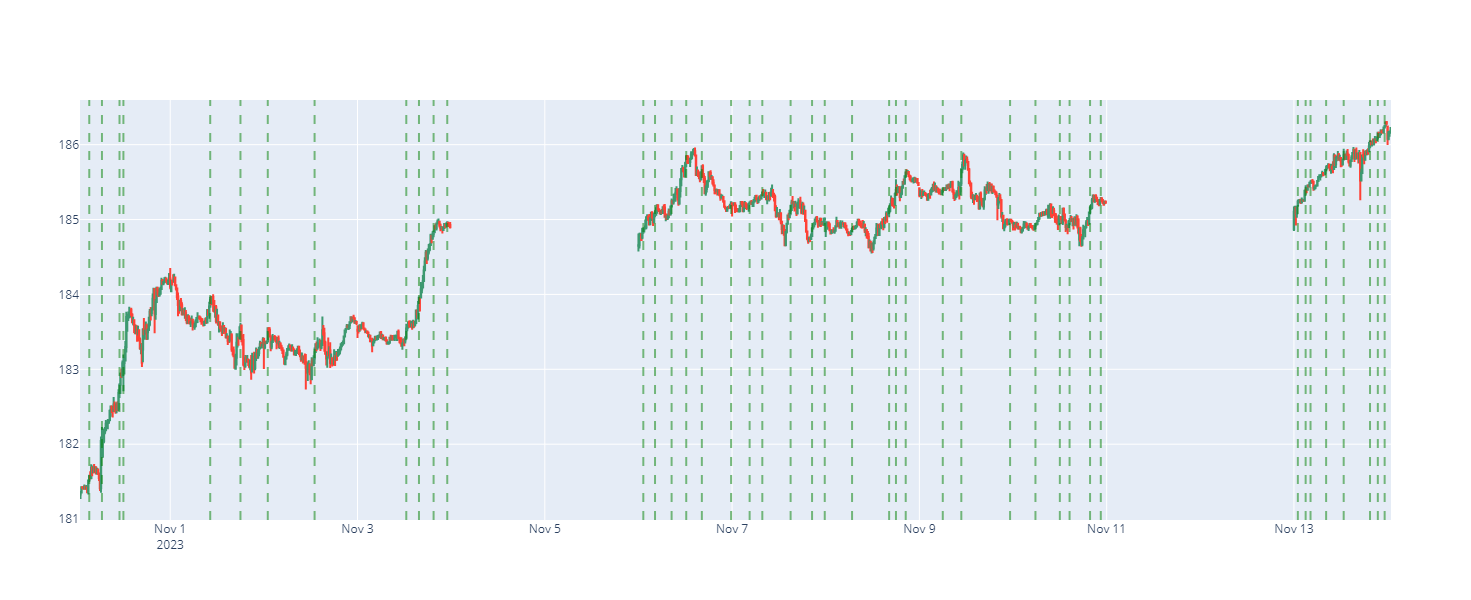

In [100]:
# visualizing the candlestick pattern

import plotly.graph_objects as go

fig_patterns = go.Figure(
    data=[go.Candlestick(
        name='GBPJPY OHLC',
        x=ohlc_df['time'],
        open=ohlc_df['open'],
        high=ohlc_df['high'],
        low=ohlc_df['low'],
        close=ohlc_df['close'],
    )]
)

fig_patterns.update_layout(xaxis_rangeslider_visible=False, height=600)

# filtering ohlc_df where pattern is True
patterns_df = ohlc_df[ohlc_df['pattern'] == True]
display(patterns_df)

# visualizing the candlestick pattern
for i in patterns_df.index:
    fig_patterns.add_vline(x=patterns_df.loc[i]['time'], line_width=2, line_dash="dash", opacity=0.5, line_color="green")
    
display(fig_patterns)